# Multi Layer Perceptron

In [36]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

BLOCK_SIZE = 3

In [2]:
# Load all the words
words = open('30k.txt', 'r').read().splitlines()

In [3]:
len(words)

30000

In [4]:
words[:5]

['the\t', 'of\t', 'and\t', 'to\t', 'a\t']

In [5]:
allWords = []
for word in words:
    newWord = ""
    for ch in list(word):
        if ch == "\t":
            break
        newWord += ch
    allWords.append(newWord)

In [6]:
allWords[:5]

['the', 'of', 'and', 'to', 'a']

In [7]:
len(allWords)

30000

In [8]:
chars = sorted(list(set(''.join(allWords))))

In [9]:
len(chars)

26

In [10]:
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}

In [11]:
stoi

{'a': 1,
 'b': 2,
 'c': 3,
 'd': 4,
 'e': 5,
 'f': 6,
 'g': 7,
 'h': 8,
 'i': 9,
 'j': 10,
 'k': 11,
 'l': 12,
 'm': 13,
 'n': 14,
 'o': 15,
 'p': 16,
 'q': 17,
 'r': 18,
 's': 19,
 't': 20,
 'u': 21,
 'v': 22,
 'w': 23,
 'x': 24,
 'y': 25,
 'z': 26,
 '.': 0}

In [26]:
block_size = 3
for word in allWords[:5]:
    context = [0] * block_size
    for ch in list(word) + ['.']:
        ix = stoi[ch]
        print(f"{''.join(itos[num] for num in context)} -> {ch}")
        context = context[1:] + [stoi[ch]]
    print("======================")

... -> t
..t -> h
.th -> e
the -> .
... -> o
..o -> f
.of -> .
... -> a
..a -> n
.an -> d
and -> .
... -> t
..t -> o
.to -> .
... -> a
..a -> .


In [40]:
# Build the dataset
def build_dataset(data):
    X, Y = [], []
    
    for word in data:
        context = [0] * BLOCK_SIZE
        for ch in list(word) + ['.']:
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
    
            context = context[1:] + [ix]
    
    X = torch.tensor(X, dtype=torch.float32)
    Y = torch.tensor(Y, dtype=torch.float32) 

    print(f"X: {X.shape}   Y: {Y.shape}")
    return X, Y


In [85]:
# Randomly shuffle the dataset and divide the data into training, testing and validataion set

import random
random.seed(1234)
random.shuffle(allWords)

Xtr, Ytr = build_dataset(allWords[:25000])
Xte, Yte = build_dataset(allWords[25000:27500])
XDev, YDev = build_dataset(allWords[27500:])

X: torch.Size([196389, 3])   Y: torch.Size([196389])
X: torch.Size([19610, 3])   Y: torch.Size([19610])
X: torch.Size([19588, 3])   Y: torch.Size([19588])


In [42]:
Xtr[:5], Ytr[:5]

(tensor([[ 0.,  0.,  0.],
         [ 0.,  0., 23.],
         [ 0., 23., 15.],
         [23., 15., 15.],
         [15., 15.,  4.]]),
 tensor([23., 15., 15.,  4.,  5.]))

In [48]:
## Form the Embeddings

EMBEDDING_DIM = 2
C = torch.rand((27, EMBEDDING_DIM))

In [52]:
C[:4]

tensor([[0.9207, 0.7339],
        [0.2124, 0.6977],
        [0.2395, 0.2861],
        [0.4241, 0.5470]])

In [86]:
block_size = 3 # context length: how many characters do we take to predict the next one?
X, Y = [], []
for w in allWords:
  
  #print(w)
  context = [0] * block_size
  for ch in w + '.':
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
    context = context[1:] + [ix] # crop and append
  
X = torch.tensor(X)
Y = torch.tensor(Y)

X.shape, Y.shape

(torch.Size([235587, 3]), torch.Size([235587]))

In [55]:
emb = C[X]

In [56]:
emb.shape

torch.Size([235587, 3, 2])

In [58]:
emb[0]

tensor([[0.9207, 0.7339],
        [0.9207, 0.7339],
        [0.9207, 0.7339]])

In [57]:
emb[0]

tensor([[0.9207, 0.7339],
        [0.9207, 0.7339],
        [0.9207, 0.7339]])

In [60]:
emb[0].view(-1, 6)

tensor([[0.9207, 0.7339, 0.9207, 0.7339, 0.9207, 0.7339]])

In [61]:
## Let's do it baby :>

In [106]:
EMBEDDING_DIM = 10
NUM_NEURONS = 50

g = torch.Generator().manual_seed(1234)
C = torch.rand((27, EMBEDDING_DIM), generator=g, requires_grad=True)    ## EMBEDDING_DIM IS THE HYPERPARAMETER WHICH CAN BE TUNED HERE

# Params for the first layer
W1 = torch.rand((EMBEDDING_DIM * BLOCK_SIZE, NUM_NEURONS), generator=g, requires_grad=True)   ## NUM_NEURONS IS THE PARAMETER WHICH CAN ALSO BE TUNED TO GET THE OPTIMAL RESULTS
b1 = torch.rand(NUM_NEURONS, generator=g, requires_grad=True)

# params for the second layer
W2 = torch.rand((NUM_NEURONS, 27), generator=g, requires_grad=True)
b2 = torch.rand(27, generator=g, requires_grad=True)

parameters = [C, W1, W2, b1, b2]

In [107]:
sum(p.nelement() for p in parameters)

3197

In [108]:
# Now is the show time

for i in range(200000):
    # Minibatch for computational ease
    ixs = torch.randint(0, Xtr.shape[0], (32, ))

    # forward pass
    emb = C[Xtr[ixs].type(torch.int32)]
    h = torch.tanh(emb.view(-1, EMBEDDING_DIM * BLOCK_SIZE) @ W1 + b1)  # first layer
    logits = h @ W2 + b2                                               # Second layer
    loss = F.cross_entropy(logits, Ytr[ixs].type(torch.int64))

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    if i % (200000 / 10) == 0:
        print(f"Iter: {i} || Loss: {loss.item()}")

Iter: 0 || Loss: 5.348620414733887
Iter: 20000 || Loss: 2.795116662979126
Iter: 40000 || Loss: 2.712987184524536
Iter: 60000 || Loss: 2.2490389347076416
Iter: 80000 || Loss: 2.1431121826171875
Iter: 100000 || Loss: 2.7145469188690186
Iter: 120000 || Loss: 2.2412524223327637
Iter: 140000 || Loss: 2.4377195835113525
Iter: 160000 || Loss: 2.2447659969329834
Iter: 180000 || Loss: 2.433130979537964


In [70]:
Xtr.dtype

torch.float32

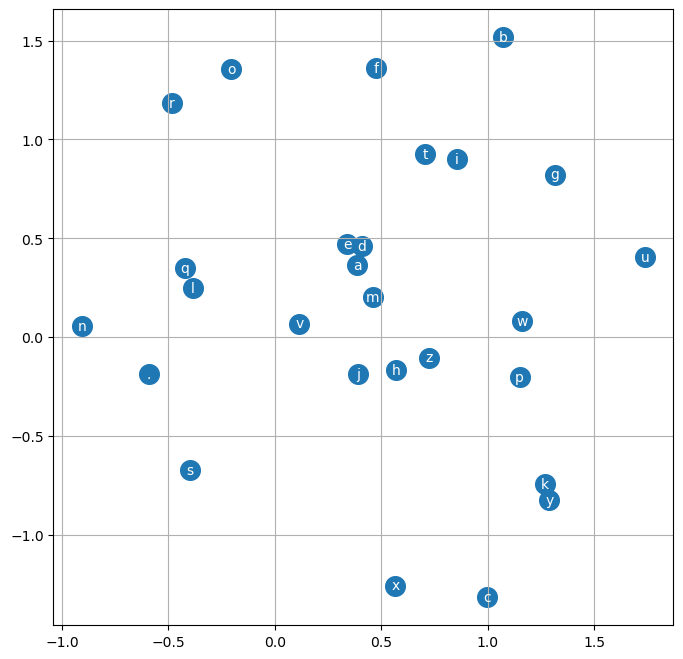

In [109]:
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [104]:
context = [0] * BLOCK_SIZE
C[torch.tensor([context])].shape

torch.Size([1, 3, 20])

In [117]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * BLOCK_SIZE # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

monationangeres.
nd.
rimpleethrecendrarg.
adered.
elithell.
pented.
poust.
farted.
bims.
tracn.
shoberging.
ins.
contreed.
spent.
ucfius.
pred.
rey.
dufmehs.
reash.
stouds.


In [113]:
emb = C[Xte.type(torch.int64)] # (32, 3, 2)
h = torch.tanh(emb.view(-1, EMBEDDING_DIM * BLOCK_SIZE) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Yte.type(torch.int64))
loss

tensor(2.2958, grad_fn=<NllLossBackward0>)